# <span style='color:#0af276'>과제 내용</span>

1) 메일 제목에 추가로 발송일자를 YYYY-MM-DD의 형태로 표시하세요 (15점)
2) 백업할 파일의 확장자를 send_backup_main() 함수를 호출할 때 지정할 수 있도록 수정하세요(15점)
3) 백업할 파일이 있는 디렉토리를  send_backup_main() 함수를 호출할 때 지정할 수 있도록 수정하세요(15점)
4) 2)번의 내용을 수정하여 다수의 확장자명(예: hwp, pptx, ipynb, xlsx 등)을 여러개 지정하여 백업할 수 있도록 수정하세요 (10점)

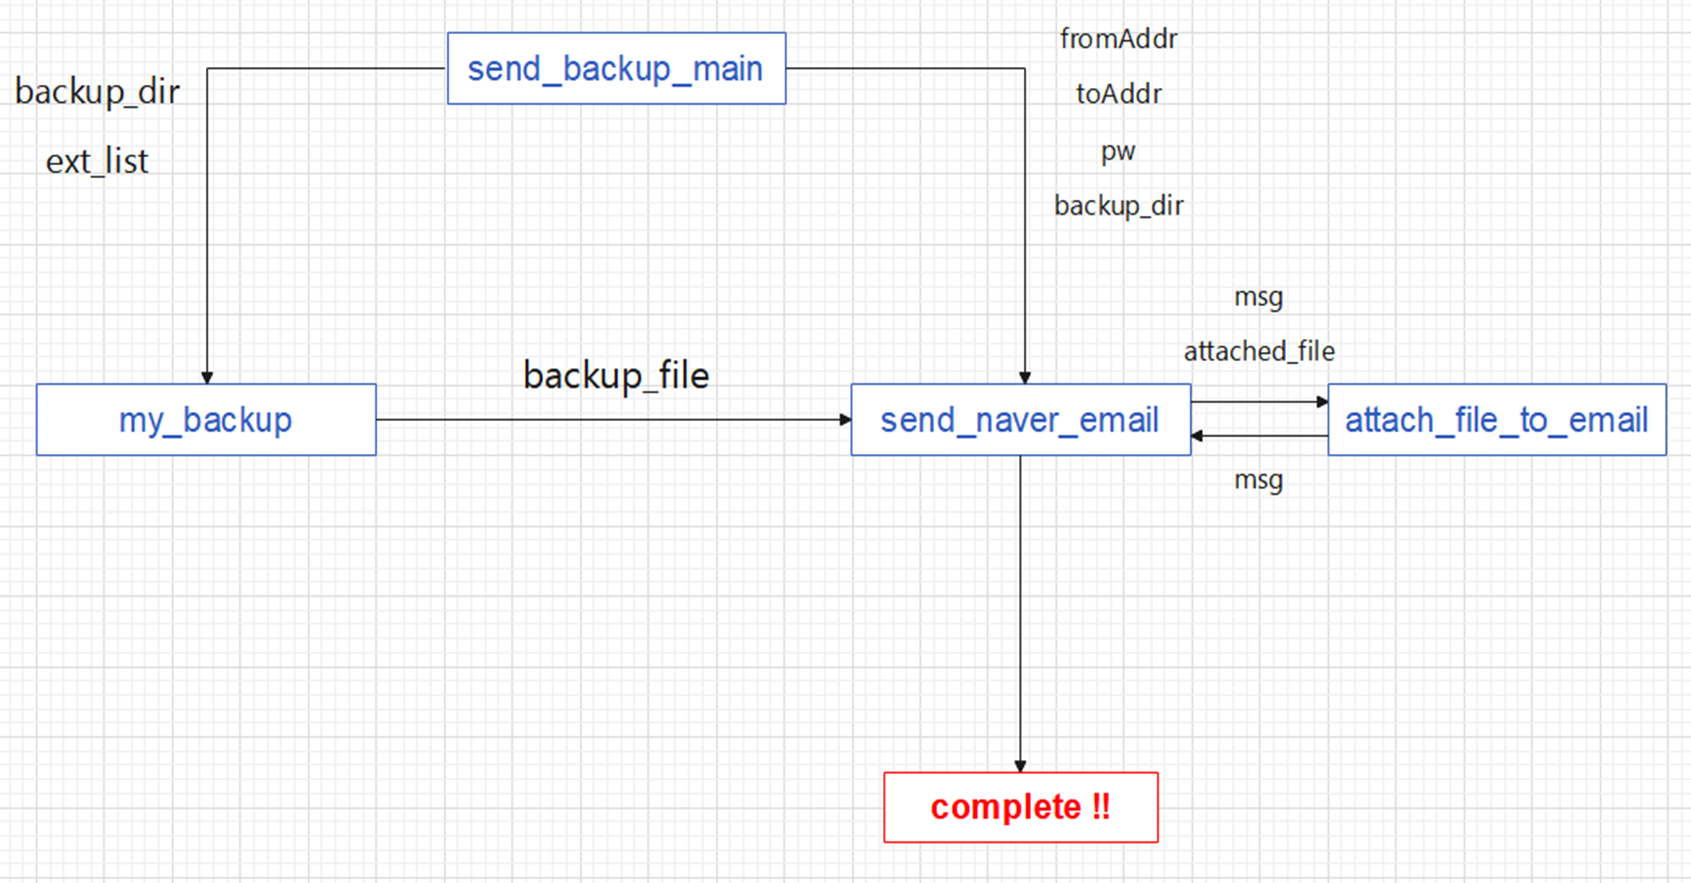

In [1]:
import os
import pickle
import smtplib   
from email import encoders  
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.header import Header  
from email.encoders import encode_base64 
import getpass

In [2]:
def my_backup(backup_dir, ext_list):
    import os
    import re
    import datetime
    import zipfile
    import shutil
    
    base_dir = "."

    if os.path.isdir(f'./{backup_dir}') == False:
        os.mkdir(f'./{backup_dir}')

    file_list = os.listdir(base_dir)
    backup_file_list = []

    # send_backup_main에서 전달한 ext_list의 value들을 re.escape와 join으로 문자열 변환
    ext_joined = '|'.join(map(re.escape, ext_list))
    regex = re.compile(rf'\.({ext_joined})$')

    for file in file_list:
        if regex.search(file) is not None:
            backup_file_list.append(file)

    for src in backup_file_list:
        shutil.copy(src, backup_dir)

    dt = datetime.datetime.now()
    backup_date = f"{dt.year:02}{dt.month:02}{dt.day:02}_{dt.hour:02}.{dt.minute:02}.{dt.second:02}"

    backup_file = backup_dir + backup_date + ".zip"

    with zipfile.ZipFile(backup_file, "w") as zipObj:
        for file in os.listdir(backup_dir):
            zipObj.write(file, compress_type=zipfile.ZIP_DEFLATED)

    remove_file_list = os.listdir(base_dir + "/" + backup_dir)
    for file in remove_file_list:
        os.remove(base_dir + "/" + backup_dir + "/" + file)

    os.rmdir(backup_dir)
    print(f'{backup_file}을 생성했습니다.')

    return backup_file  # send_naver_email로 전달

In [3]:
def send_naver_email(fromAddr, toAddr, pw, attached_file, backup_dir):
    import datetime
    naver = smtplib.SMTP('smtp.naver.com', 587)
    naver.ehlo()
    naver.starttls()
    
    naver.login(fromAddr, pw)
    
    msg = MIMEMultipart("mixed") 
    msg.preamble = ''

    # 조건 1) 메일 제목에 추가로 발송일자를 YYYY-MM-DD의 형태로 표시
    msg['Subject'] = Header(f'{attached_file} : ({datetime.datetime.now().strftime("%Y-%m-%d")})', 'utf8')
    msg['From'] = fromAddr
    msg['To'] = toAddr
    txt = f'''
    ※ 본 메일은 비즈니스코딩 기말과제 코드를 사용하여 발송합니다.
    [{backup_dir}] 디렉토리를 백업한 압축파일 '{attached_file}'을 보냅니다.
    메일이 왔다면 정상적으로 동작하는 것입니다! 감사합니다 ☺
    '''
    msg.attach(MIMEText(txt, _charset="utf8"))
    attach_file_to_email(msg, attached_file) # attach_file_to_email로 전달
    
    naver.sendmail(fromAddr, toAddr, msg.as_string())
    naver.close()
    print(f"{attached_file}을 {toAddr}에게 전송했습니다.")

In [4]:
def attach_file_to_email(msg, attached_file=""):
    try:
        if attached_file is not None:
            part = MIMEBase("application", "octet-stream", _charset="utf8")
            part.set_payload(open(attached_file, "rb").read())
            encode_base64(part)
            part.add_header(
                "Content-Disposition",
                "attachment",
                filename=("utf8", "", os.path.basename(attached_file))
            )
            msg.attach(part)
            return msg # send_naver_email로 전달

    except FileNotFoundError:
        return "첨부 파일이 지정한 위치에 없습니다."

In [5]:
def send_backup_main():
    # 조건 3) 백업할 파일이 있는 디렉토리를 send_backup_main() 함수를 호출할 때 지정
    while True:
        backup_dir = input("백업할 디렉토리 이름을 입력 ▶ ")
        if backup_dir.strip() != '':
            break
        else:
            print("공백은 입력할 수 없습니다. 최소 1자 이상 입력하세요.")
            
    # 조건 2) 백업할 파일의 확장자를 send_backup_main() 함수를 호출할 때 지정
    # 조건 4) 다수의 확장자명(ex: hwp, pptx, ipynb, xlsx 등)을 여러개 지정 가능
    while True:
        backup_ext = input("백업할 파일의 확장자를 입력 (ex: txt, ipynb, xlsx 등) ▶ ")
        ext_list = [e.strip() for e in backup_ext.split(',') if e.strip()]
        if ext_list:
            break
        else:
            print("적어도 하나의 확장자를 입력하세요.")

            
    while True:
        fromAddr = input("발송자의 네이버 이메일 주소 입력 ▶ ")
        mail_check = input("입력한 이메일 주소가 맞습니까? (Y or N) ▶ ")
        if mail_check.lower() in ["y", "n"]:
            if mail_check.lower() == "y":
                break
        else:
            print("주소가 맞다면 Y, 틀리면 N을 입력하세요.")

    toAddr = fromAddr
    pw = getpass.getpass(f"{fromAddr}의 패스워드 입력 ▶ ")

    backup_file = my_backup(backup_dir, ext_list)
    send_naver_email(fromAddr, toAddr, pw, backup_file, backup_dir)
    print(f'오류 없음. 확장자 {ext_list} 파일 백업 및 메일 전송 성공.')

In [7]:
# 메인 함수 실행
send_backup_main()

백업할 디렉토리 이름을 입력 ▶  pdf와txt만
백업할 파일의 확장자를 입력 (ex: txt, ipynb, xlsx 등) ▶  pdf, txt
발송자의 네이버 이메일 주소 입력 ▶  gn05046@naver.com
입력한 이메일 주소가 맞습니까? (Y or N) ▶  wjfeo$ozld5ht


주소가 맞다면 Y, 틀리면 N을 입력하세요.


발송자의 네이버 이메일 주소 입력 ▶  gn05046@naver.com
입력한 이메일 주소가 맞습니까? (Y or N) ▶  y
gn05046@naver.com의 패스워드 입력 ▶  ········


pdf와txt만20231226_22.49.04.zip을 생성했습니다.
pdf와txt만20231226_22.49.04.zip을 gn05046@naver.com에게 전송했습니다.
오류 없음. 확장자 ['pdf', 'txt'] 파일 백업 및 메일 전송 성공.
